In [36]:
import itertools
from collections import defaultdict
import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm import tqdm
import time
import random
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

MongolianTentGraph(n=20, edges=117)

Initial graph with all labels = 1:


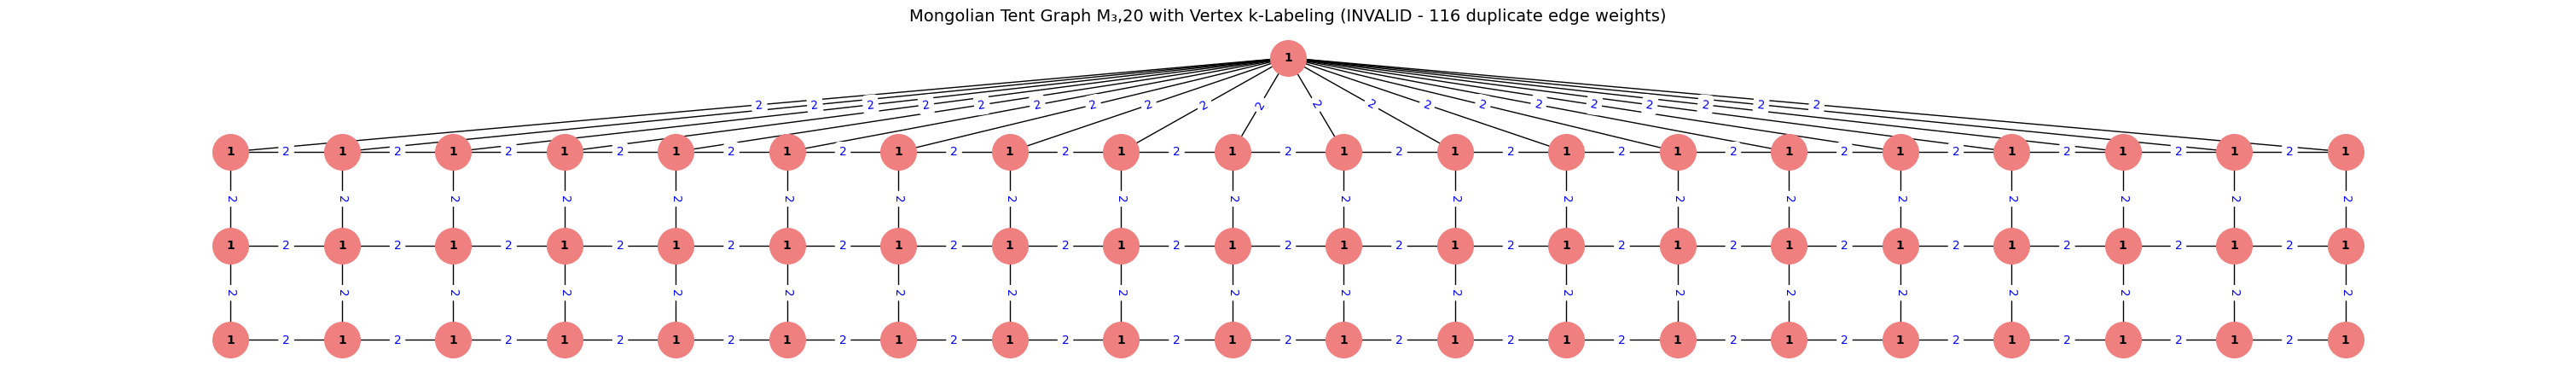

Edge weights: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Unique weights: 1/117
Duplicate weights: {2: 117}

Finding edge irregularity strength...
Graph: MongolianTentGraph(n=20, edges=117)
Edge count: 117
Max degree: 20
Search range: k ∈ [59, 100]













Searching k:  12%|█▏        | 5/42 [16:13<2:00:07, 194.80s/it, k=59]


Edge irregularity strength es(G): 60
Vertex labels: {0: 30, 1: 2, 2: 3, 3: 5, 4: 8, 5: 13, 6: 21, 7: 34, 8: 55, 9: 56, 10: 57, 11: 58, 12: 59, 13: 60, 14: 35, 15: 36, 16: 37, 17: 38, 18: 39, 19: 42, 20: 58, 21: 42, 22: 60, 23: 47, 24: 38, 25: 4, 26: 6, 27: 42, 28: 59, 29: 49, 30: 5, 31: 7, 32: 8, 33: 60, 34: 56, 35: 13, 36: 37, 37: 59, 38: 40, 39: 44, 40: 35, 41: 52, 42: 12, 43: 4, 44: 3, 45: 20, 46: 27, 47: 56, 48: 50, 49: 54, 50: 24, 51: 4, 52: 22, 53: 58, 54: 54, 55: 12, 56: 8, 57: 11, 58: 42, 59: 48, 60: 1}

Graph with optimal labeling:


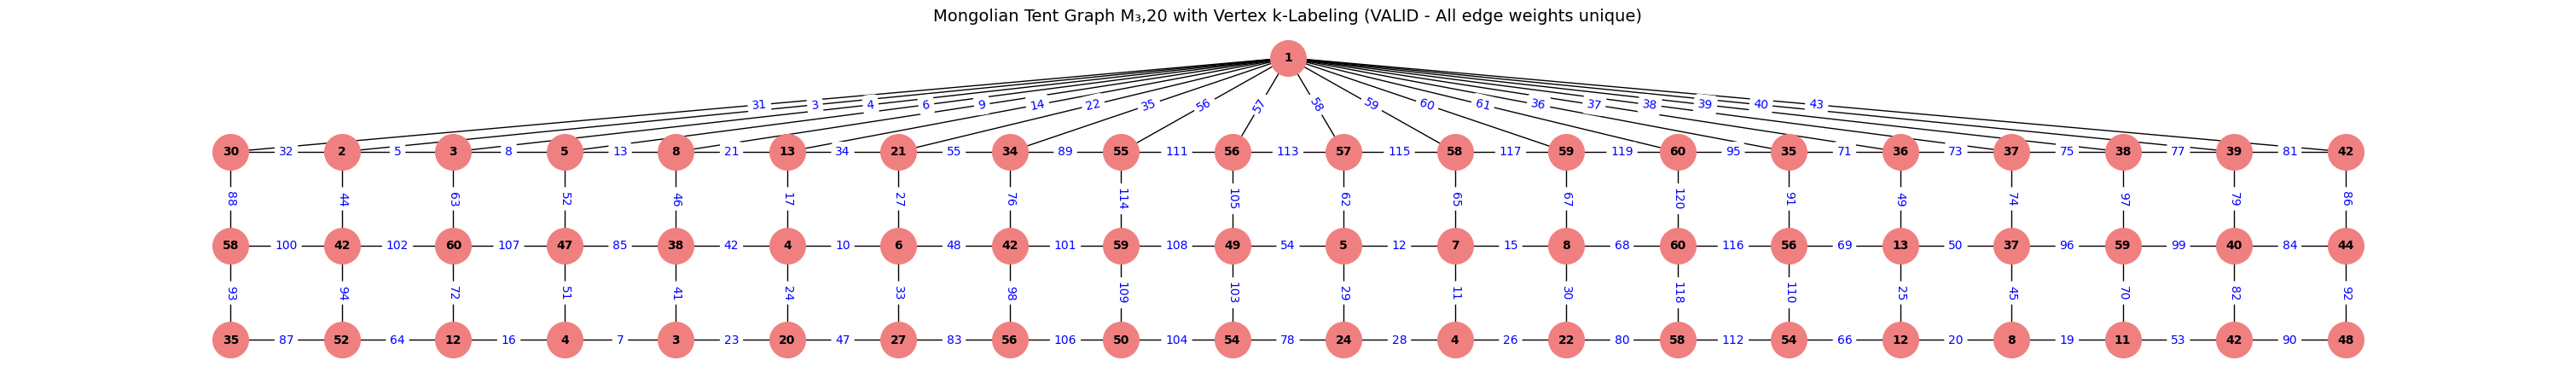

Edge weights: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]
Unique weights: 117/117


In [47]:
class MongolianTentGraph:
    def __init__(self, n):
        self.n = n
        self.adj = {}
        self.build_graph()

    def __repr__(self):
        return f"MongolianTentGraph(n={self.n}, edges={len(self.compute_edges())})"

    def node_id(self, row, col):
        """Generate a unique node ID for the grid position (row, col)"""
        return row * self.n + col

    def build_graph(self):
        # Build the grid P_3 x P_n
        for row in range(3):
            for col in range(self.n):
                curr = self.node_id(row, col)
                self.adj[curr] = []

                # Connect to right neighbor
                if col + 1 < self.n:
                    self.adj[curr].append(self.node_id(row, col + 1))

                # Connect to bottom neighbor
                if row + 1 < 3:
                    self.adj[curr].append(self.node_id(row + 1, col))

                # Connect left and top neighbors (implicitly)
                if col - 1 >= 0:
                    self.adj[curr].append(self.node_id(row, col - 1))
                if row - 1 >= 0:
                    self.adj[curr].append(self.node_id(row - 1, col))

        # Add the tent peak node and connect to every top-row vertex
        tent_peak = 3 * self.n
        self.adj[tent_peak] = []
        for col in range(0, self.n):
            top_row_node = self.node_id(0, col)
            self.adj[tent_peak].append(top_row_node)
            self.adj[top_row_node].append(tent_peak)

    def compute_edges(self):
        """Convert adjacency list to undirected edge list without duplicates"""
        edges = set()
        for u in self.adj:
            for v in self.adj[u]:
                if u < v:
                    edges.add((u, v))
        return list(edges)

    def max_degree(self):
        return max(len(self.adj[v]) for v in self.adj)
    
    def draw(self, labels):
        """Draw the Mongolian Tent graph with given vertex labels"""
        G = nx.Graph()

        # Add nodes and edges
        for u in self.adj:
            G.add_node(u)
            for v in self.adj[u]:
                if u < v:
                    G.add_edge(u, v)

        # Compute positions
        pos = {}
        for row in range(3):
            for col in range(self.n):
                node = self.node_id(row, col)
                pos[node] = (col, -row)
        tent_peak = 3 * self.n
        pos[tent_peak] = ((self.n - 1) / 2, 1)

        # Compute edge labels as sum of vertex labels
        edge_labels = {
            (u, v): labels[u] + labels[v]
            for u, v in G.edges()
        }

        # Check for duplicate edge weights
        edge_weights = list(edge_labels.values())
        unique_weights = len(set(edge_weights))
        total_edges = len(edge_weights)
        
        # Draw the graph
        plt.figure(figsize=(1.5 * self.n, 4))
        nx.draw(G, pos, with_labels=True, labels=labels,
                node_color="lightcoral", node_size=900, font_size=10, font_weight="bold")

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=10)

        title = f"Mongolian Tent Graph M₃,{self.n} with Vertex k-Labeling"
        if unique_weights == total_edges:
            title += " (VALID - All edge weights unique)"
        else:
            title += f" (INVALID - {total_edges - unique_weights} duplicate edge weights)"
        
        plt.title(title, fontsize=14)
        plt.axis("off")
        plt.show()
        
        # Print edge weight analysis
        print(f"Edge weights: {sorted(edge_weights)}")
        print(f"Unique weights: {unique_weights}/{total_edges}")
        if unique_weights != total_edges:
            from collections import Counter
            weight_counts = Counter(edge_weights)
            duplicates = {w: count for w, count in weight_counts.items() if count > 1}
            print(f"Duplicate weights: {duplicates}")

def label_graph_constraint_propagation(graph, k, max_time=60):
    """
    Fast k-labeling using constraint propagation and intelligent heuristics
    """
    vertices = list(graph.adj.keys())
    edges = graph.compute_edges()
    
    # Sort vertices by degree (highest first) then by structural importance
    tent_peak = 3 * graph.n  # The tent peak has highest degree
    vertices.sort(key=lambda v: (-len(graph.adj[v]), v == tent_peak, v))
    
    labels = {}
    used_edge_weights = set()
    start_time = time.time()
    
    # Domain for each vertex: possible labels
    domains = {v: set(range(1, k + 1)) for v in vertices}
    
    def propagate_constraints(vertex, label):
        """Propagate constraints after assigning label to vertex"""
        changes = []
        
        for neighbor in graph.adj[vertex]:
            if neighbor not in labels:  # Neighbor not yet labeled
                # Remove labels that would create duplicate edge weights
                invalid_labels = set()
                for nlabel in domains[neighbor]:
                    weight = label + nlabel
                    if weight in used_edge_weights:
                        invalid_labels.add(nlabel)
                
                if invalid_labels:
                    old_domain = domains[neighbor].copy()
                    domains[neighbor] -= invalid_labels
                    changes.append((neighbor, old_domain))
                    
                    if not domains[neighbor]:  # Empty domain = dead end
                        return False, changes
        
        return True, changes
    
    def restore_domains(changes):
        """Restore domains after backtracking"""
        for vertex, old_domain in changes:
            domains[vertex] = old_domain
    
    def select_next_vertex():
        """Select vertex with smallest domain (most constrained first)"""
        unlabeled = [v for v in vertices if v not in labels]
        if not unlabeled:
            return None
        return min(unlabeled, key=lambda v: (len(domains[v]), -len(graph.adj[v])))
    
    def select_label_order(vertex):
        """Order labels by how much they constrain other vertices"""
        available = list(domains[vertex])
        
        # Simple heuristic: prefer labels that create fewer conflicts
        def conflict_score(label):
            conflicts = 0
            for neighbor in graph.adj[vertex]:
                if neighbor not in labels:
                    for nlabel in domains[neighbor]:
                        if label + nlabel in used_edge_weights:
                            conflicts += 1
            return conflicts
        
        available.sort(key=conflict_score)
        return available
    
    def backtrack():
        if time.time() - start_time > max_time:
            return False
        
        vertex = select_next_vertex()
        if vertex is None:
            return True  # All vertices labeled
        
        for label in select_label_order(vertex):
            if label not in domains[vertex]:
                continue
                
            # Try assignment
            labels[vertex] = label
            new_weights = []
            
            # Add new edge weights
            for neighbor in graph.adj[vertex]:
                if neighbor in labels:
                    weight = label + labels[neighbor]
                    if weight in used_edge_weights:
                        # Conflict! Backtrack immediately
                        del labels[vertex]
                        break
                    used_edge_weights.add(weight)
                    new_weights.append(weight)
            else:
                # No immediate conflicts, propagate constraints
                success, changes = propagate_constraints(vertex, label)
                
                if success and backtrack():
                    return True
                
                # Backtrack
                restore_domains(changes)
                
            # Remove assignment
            if vertex in labels:
                del labels[vertex]
            for weight in new_weights:
                used_edge_weights.discard(weight)
        
        return False
    
    success = backtrack()
    return success, labels if success else None


def find_edge_irregularity_strength(graph):
    """Find minimal k where valid vertex k-labeling gives unique edge weights"""
    edge_count = len(graph.compute_edges())
    
    # Theoretical lower bound: we need at least enough different sums
    # to create unique edge weights
    lower = math.ceil(math.sqrt(2 * edge_count))
    
    # More conservative lower bound based on the structure
    lower = max(lower, math.ceil((edge_count + 1) / 2))
    
    # Upper bound: at most 2 * edge_count should be sufficient
    upper = min(2 * edge_count, 100)  # Cap at 100 for practical reasons
    
    print(f"Graph: {graph}")
    print(f"Edge count: {edge_count}")
    print(f"Max degree: {graph.max_degree()}")
    print(f"Search range: k ∈ [{lower}, {upper}]")
    
    # Linear search for smaller ranges, binary search for larger
    if upper - lower <= 20:
        # Linear search
        for k in range(lower, upper + 1):
            print(f"Trying k = {k}...")
            success, labels = label_graph_constraint_propagation(graph, k)
            if success:
                print(f"Found valid labeling with k = {k}")
                return k, labels
        print("No valid labeling found in search range")
        return None, None
    else:
        # Binary search
        pbar = tqdm(total=upper - lower + 1, desc="Searching k")
        
        while lower < upper:
            mid = (lower + upper) // 2
            pbar.set_postfix({"k": mid})
            success, labels = label_graph_constraint_propagation(graph, mid)
            if success:
                upper = mid
            else:
                lower = mid + 1
            pbar.update(1)
        
        pbar.close()
        
        # Verify the final result
        if lower <= upper:
            success, labels = label_graph_constraint_propagation(graph, lower)
            if success:
                return lower, labels
        
        return None, None

graph = MongolianTentGraph(n=20)
print(graph)

# Show the initial graph with all labels = 1 (should be invalid)
print("\nInitial graph with all labels = 1:")
graph.draw(labels={v: 1 for v in graph.adj.keys()})

# Find the edge irregularity strength
print("\nFinding edge irregularity strength...")
es, labels = find_edge_irregularity_strength(graph)

if es is not None:
    print(f"\nEdge irregularity strength es(G): {es}")
    print(f"Vertex labels: {dict(sorted(labels.items()))}")
    print("\nGraph with optimal labeling:")
    graph.draw(labels=labels)
else:
    print("Could not find a valid labeling in the search range")

In [48]:
def find_edge_irregularity_strength_timed(graph):
    """Find minimal k with timing information"""
    edge_count = len(graph.compute_edges())
    
    lower = math.ceil(math.sqrt(2 * edge_count))
    
    lower = max(lower, math.ceil((edge_count + 1) / 2))
    
    upper = min(2 * edge_count, 100)  # Cap at 100 for practical reasons
    
    start_time = time.time()
    
    for k in range(lower, upper + 1):
        success, labels = label_graph_constraint_propagation(graph, k)
        if success:
            return k, labels, time.time() - start_time
    
    return None, None, time.time() - start_time

In [ ]:
def benchmark_complexity():
    """
    Comprehensive benchmarking of the algorithm's time complexity
    """
    # Test different graph sizes
    test_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]
    
    results = []
    
    print("Running complexity benchmarks...")
    print("=" * 60)
    
    for n in test_sizes:
        print(f"Testing n={n}...")
        
        # Create graph and gather metrics
        graph = MongolianTentGraph(n)
        vertices = len(graph.adj)
        edges = len(graph.compute_edges())
        max_degree = graph.max_degree()
        
        # Time the algorithm (multiple runs for accuracy)
        times = []
        successful_runs = 0
        
        for run in range(3):  # 3 runs for averaging
            k, labels, elapsed = find_edge_irregularity_strength_timed(graph)
            if k is not None:
                times.append(elapsed)
                successful_runs += 1
        
        if times:
            avg_time = np.mean(times)
            std_time = np.std(times) if len(times) > 1 else 0
            
            results.append({
                'n': n,
                'vertices': vertices,
                'edges': edges,
                'max_degree': max_degree,
                'avg_time': avg_time,
                'std_time': std_time,
                'successful_runs': successful_runs,
                'k_found': k
            })
            
            print(f"  V={vertices}, E={edges}, Time={avg_time:.4f}s ± {std_time:.4f}s, k={k}")
    
    return pd.DataFrame(results)

def analyze_complexity_curves(df):
    """
    Analyze the time complexity by fitting various complexity curves
    """
    if len(df) == 0:
        print("No data to analyze!")
        return
    
    # Extract data
    V = df['vertices'].values
    E = df['edges'].values
    times = df['avg_time'].values
    
    # Define complexity functions to test
    complexity_functions = {
        'O(V)': lambda x: x,
        'O(E)': lambda x: df['edges'].values,
        'O(V log V)': lambda x: x * np.log(x),
        'O(E log V)': lambda x: df['edges'].values * np.log(x),
        'O(V²)': lambda x: x ** 2,
        'O(E²)': lambda x: df['edges'].values ** 2,
        'O(V³)': lambda x: x ** 3,
        'O(2^V)': lambda x: 2 ** (x * 0.1),  # Scaled down exponential
        'O(V!)': lambda x: np.array([math.factorial(min(int(v), 10)) for v in x])  # Capped factorial
    }
    
    # Fit curves and calculate correlation coefficients
    correlations = {}
    fitted_params = {}
    
    for name, func in complexity_functions.items():
        try:
            predicted = func(V)
            
            # Handle edge-based functions
            if 'E' in name and 'log' not in name:
                predicted = func(E)
            
            # Normalize to avoid numerical issues
            if np.max(predicted) > 0:
                predicted = predicted / np.max(predicted) * np.max(times)
            
            # Calculate correlation
            if len(predicted) > 1 and np.std(predicted) > 0:
                corr, _ = pearsonr(predicted, times)
                correlations[name] = corr
                
                # Fit a linear scaling factor
                try:
                    def linear_fit(x, a):
                        return a * func(x)
                    
                    popt, _ = curve_fit(linear_fit, V, times, maxfev=1000)
                    fitted_params[name] = popt[0]
                except:
                    fitted_params[name] = 1.0
            else:
                correlations[name] = 0.0
                fitted_params[name] = 1.0
                
        except Exception as e:
            correlations[name] = 0.0
            fitted_params[name] = 1.0
    
    # Sort by correlation
    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print("\n" + "=" * 60)
    print("COMPLEXITY ANALYSIS RESULTS")
    print("=" * 60)
    
    print(f"{'Complexity':<12} {'Correlation':<12} {'Abs Corr':<12} {'Fit Quality'}")
    print("-" * 50)
    
    for name, corr in sorted_correlations:
        abs_corr = abs(corr)
        if abs_corr > 0.9:
            quality = "Excellent"
        elif abs_corr > 0.7:
            quality = "Good"
        elif abs_corr > 0.5:
            quality = "Fair"
        else:
            quality = "Poor"
        
        print(f"{name:<12} {corr:>8.4f}    {abs_corr:>8.4f}    {quality}")
    
    return correlations, fitted_params

def plot_complexity_analysis(df, correlations, fitted_params):
    """
    Create comprehensive plots showing the algorithm's complexity
    """
    if len(df) == 0:
        print("No data to plot!")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Mongolian Tent Graph Algorithm - Time Complexity Analysis', fontsize=16)
    
    V = df['vertices'].values
    E = df['edges'].values
    times = df['avg_time'].values
    
    # Plot 1: Raw timing data
    ax1 = axes[0, 0]
    ax1.errorbar(V, times, yerr=df['std_time'], fmt='bo-', capsize=5, markersize=8)
    ax1.set_xlabel('Vertices (V)')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Raw Timing Data')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Top complexity curves
    ax2 = axes[0, 1]
    ax2.plot(V, times, 'bo-', label='Actual', markersize=8, linewidth=2)
    
    # Plot top 3 correlations
    top_3 = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:3]
    
    colors = ['red', 'green', 'orange']
    for i, (name, corr) in enumerate(top_3):
        try:
            if 'V²' in name:
                curve = fitted_params[name] * (V ** 2)
            elif 'V³' in name:
                curve = fitted_params[name] * (V ** 3)
            elif 'E²' in name:
                curve = fitted_params[name] * (E ** 2)
            elif 'V log V' in name:
                curve = fitted_params[name] * V * np.log(V)
            elif 'E log V' in name:
                curve = fitted_params[name] * E * np.log(V)
            elif 'O(V)' in name:
                curve = fitted_params[name] * V
            elif 'O(E)' in name:
                curve = fitted_params[name] * E
            else:
                continue
            
            ax2.plot(V, curve, color=colors[i], linestyle='--', 
                    label=f'{name} (r={corr:.3f})', linewidth=2)
        except:
            continue
    
    ax2.set_xlabel('Vertices (V)')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Best Fitting Complexity Curves')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Vertices vs Edges relationship
    ax3 = axes[1, 0]
    ax3.plot(V, E, 'go-', markersize=8, linewidth=2)
    ax3.set_xlabel('Vertices (V)')
    ax3.set_ylabel('Edges (E)')
    ax3.set_title('Graph Size Scaling (V vs E)')
    ax3.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(V, E, 1)
    p = np.poly1d(z)
    ax3.plot(V, p(V), "r--", alpha=0.8, label=f'E ≈ {z[0]:.2f}V + {z[1]:.2f}')
    ax3.legend()
    
    # Plot 4: Log-log plot for better trend visualization
    ax4 = axes[1, 1]
    ax4.loglog(V, times, 'bo-', markersize=8, linewidth=2, label='Actual')
    
    # Add theoretical curves in log-log space
    V_smooth = np.linspace(min(V), max(V), 100)
    
    # Fit power law: T = a * V^b
    try:
        log_V = np.log(V)
        log_times = np.log(times)
        z = np.polyfit(log_V, log_times, 1)
        power_law_exp = z[0]
        
        fitted_curve = np.exp(z[1]) * (V_smooth ** power_law_exp)
        ax4.loglog(V_smooth, fitted_curve, 'r--', linewidth=2, 
                  label=f'Power Law: T ∝ V^{power_law_exp:.2f}')
    except:
        pass
    
    ax4.set_xlabel('Vertices (V) - Log Scale')
    ax4.set_ylabel('Time (seconds) - Log Scale')
    ax4.set_title('Log-Log Plot for Power Law Detection')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "=" * 60)
    print("COMPLEXITY SUMMARY")
    print("=" * 60)
    
    try:
        log_V = np.log(V)
        log_times = np.log(times)
        z = np.polyfit(log_V, log_times, 1)
        power_law_exp = z[0]
        
        print(f"Power Law Analysis: T ∝ V^{power_law_exp:.2f}")
        
        if power_law_exp < 1.5:
            complexity_class = "Sub-quadratic (better than O(V²))"
        elif power_law_exp < 2.5:
            complexity_class = "Quadratic-like (O(V²))"
        elif power_law_exp < 3.5:
            complexity_class = "Cubic-like (O(V³))"
        else:
            complexity_class = "Higher than cubic"
            
        print(f"Estimated Complexity Class: {complexity_class}")
        
    except Exception as e:
        print(f"Could not determine power law: {e}")
    
    # Graph structure analysis
    print(f"\nGraph Structure Analysis:")
    print(f"- Vertices scale as: V = 3n + 1")
    print(f"- Edges scale as: E ≈ {np.polyfit(V, E, 1)[0]:.2f}V + {np.polyfit(V, E, 1)[1]:.2f}")
    print(f"- Maximum degree: {df['max_degree'].max()}")

Mongolian Tent Graph Algorithm - Time Complexity Benchmark
Running complexity benchmarks...
Testing n=3...
  V=10, E=15, Time=0.0742s ± 0.0074s, k=8
Testing n=4...
  V=13, E=21, Time=3.8015s ± 0.0090s, k=11
Testing n=5...
  V=16, E=27, Time=2.0678s ± 0.0530s, k=14
Testing n=6...
  V=19, E=33, Time=0.7107s ± 0.0007s, k=17
Testing n=7...
  V=22, E=39, Time=2.1859s ± 0.0317s, k=20
Testing n=8...
  V=25, E=45, Time=6.6113s ± 0.0700s, k=23
Testing n=9...
  V=28, E=51, Time=35.8203s ± 0.2272s, k=26
Testing n=10...
  V=31, E=57, Time=4.1086s ± 0.0251s, k=29
Testing n=12...
  V=37, E=69, Time=62.1850s ± 0.0217s, k=36
Testing n=14...
  V=43, E=81, Time=60.2705s ± 0.0101s, k=42
Testing n=16...
  V=49, E=93, Time=90.3826s ± 0.2121s, k=48
Testing n=18...
  V=55, E=105, Time=75.2304s ± 0.0496s, k=54
Testing n=20...
  V=61, E=117, Time=118.8562s ± 0.2231s, k=60

Successfully benchmarked 13 different graph sizes

Detailed Results:
 n  vertices  edges  max_degree   avg_time  std_time  successful_runs 

/tmp/ipykernel_12813/1563356073.py:97: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(predicted, times)


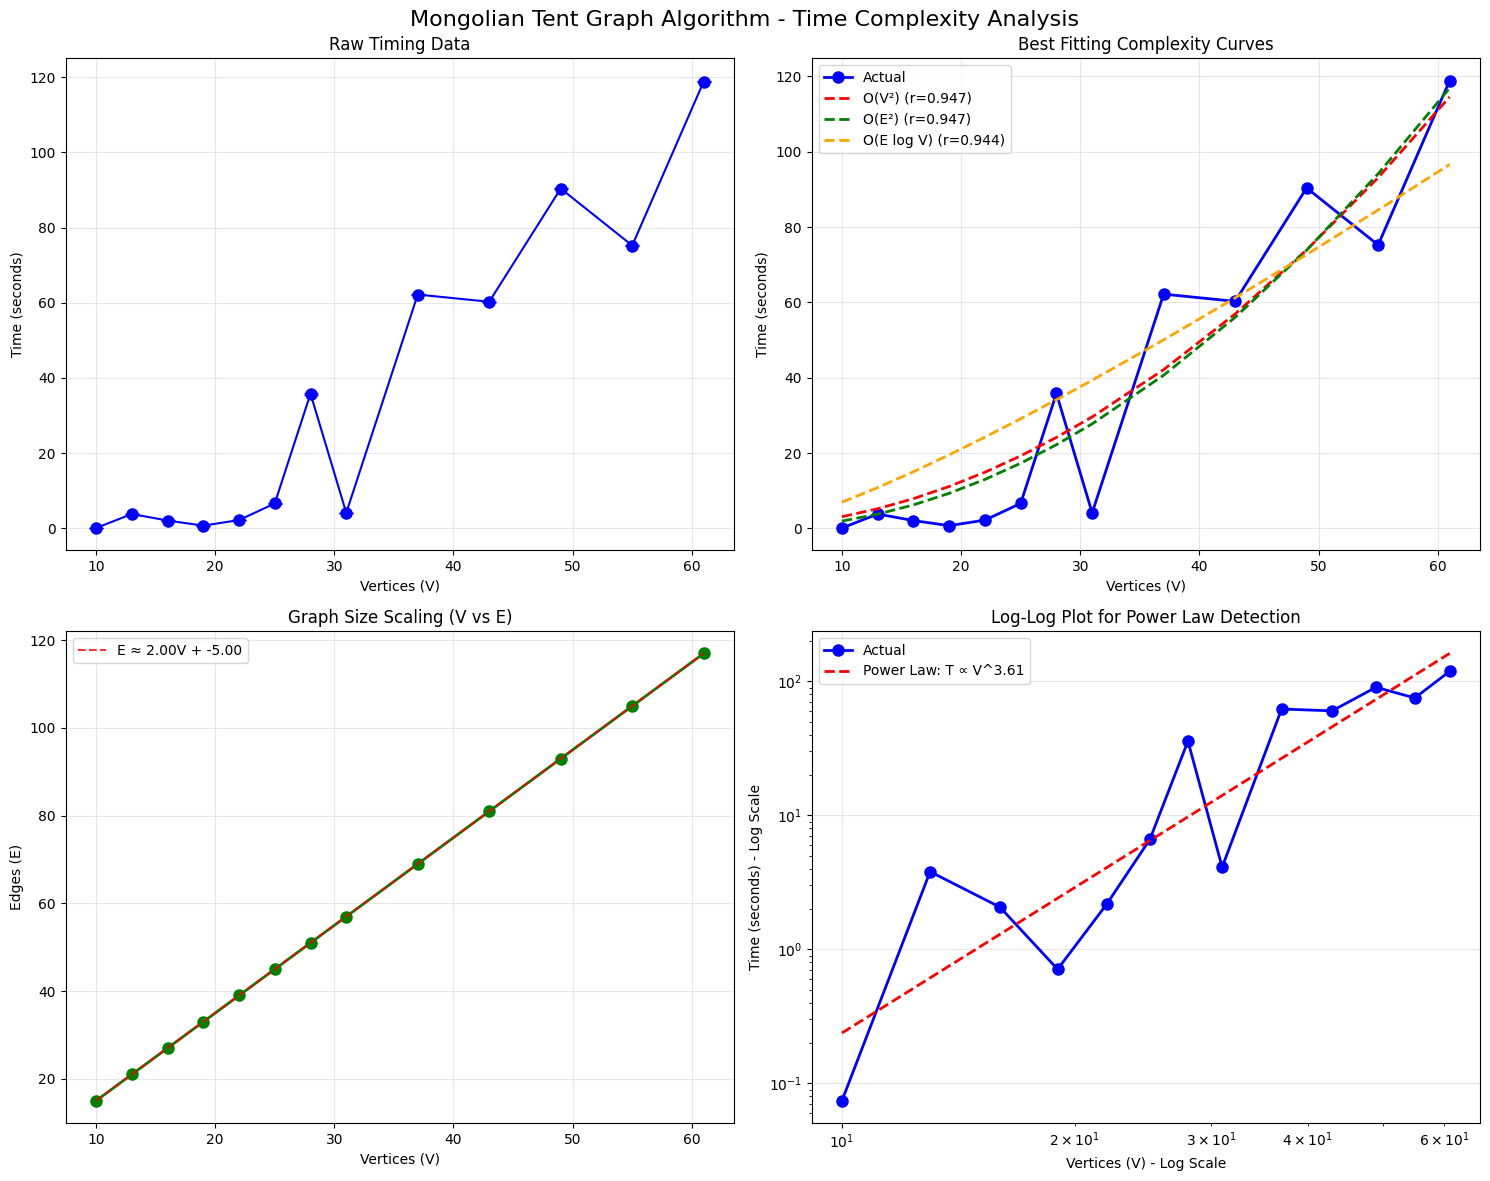


COMPLEXITY SUMMARY
Power Law Analysis: T ∝ V^3.61
Estimated Complexity Class: Higher than cubic

Graph Structure Analysis:
- Vertices scale as: V = 3n + 1
- Edges scale as: E ≈ 2.00V + -5.00
- Maximum degree: 20


In [49]:
print("Mongolian Tent Graph Algorithm - Time Complexity Benchmark")
print("=" * 60)

# Run benchmarks
df = benchmark_complexity()

if len(df) == 0:
    print("No successful runs to analyze!")
else:
    print(f"\nSuccessfully benchmarked {len(df)} different graph sizes")
    print("\nDetailed Results:")
    print(df.to_string(index=False))

    # Analyze complexity
    correlations, fitted_params = analyze_complexity_curves(df)

    # Create plots
    plot_complexity_analysis(df, correlations, fitted_params)